# Presenting main functionality

Example created by Wilson Rocha Lacerda Junior

Here we import the NARMAX model, the metric for model evaluation and the methods to generate sample data for tests. Also, we import pandas for specific usage.

In [ ]:
pip install sysidentpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

## Generating 1 input 1 output sample data  

The data is generated by simulating the following model:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.1$

In the next example we will generate a data with 1000 samples with white noise and selecting 90% of the data to train the model. 

In [3]:
x_train, x_valid, y_train, y_valid = get_siso_data(
    n=1000, colored_noise=False, sigma=0.0001, train_percentage=90
)

To obtain a NARMAX model we have to choose some values, *e.g*, the nonlinearity degree (*non_degree*), the maximum lag for the inputs and output (*xlag* and *ylag*). 

In addition, you can select the information criteria to be used with the Error Reduction Ratio to select the model order and the method to estimate the model parameters:

- Information Criteria: aic, bic, lilc, fpe
- Parameter Estimation: least_squares, total_least_squares, recursive_least_squares, least_mean_squares and many other (see the docs)

The *n_terms* values is optional. It refer to the number of terms to include in the final model. You can set this value based on the information criteria (see below) or based on priori information about the model structure. The default value is *n_terms=None*, so the algorithm will choose the minimum value reached by the information criteria.

To use information criteria you have to set *order_selection=True*. You can also select *n_info_values* (default = 15).

In [4]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=3,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)

C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


## Model Structure Selection

The *fit* method executes the Error Reduction Ratio algorithm using Househoulder reflection to select the model structure.

Enforcing keyword-only arguments in *fit* and *predict* methods as well. This is an effort to promote clear and non-ambiguous use of the library.

In [5]:
model.fit(X=x_train, y=y_train)

## Free run simulation

The *predict* method is use to generate the predictions. For now we only support *free run simulation* (also known as *infinity steps ahead*). Soon will let the user define a *one-step ahead* or *k-step ahead* prediction.

In [6]:
yhat = model.predict(X=x_valid, y=y_valid)

## Evaluate the model

In this example we use the *root_relative_squared_error* metric because it is often used in System Identification. More metrics and information about it can be found on documentation.

In [7]:
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

0.00018456924095005924


*model_object.results* return the selected model regressors, the estimated parameters and the ERR values. As shown below, the algorithm detect the exact model that was used for simulate the data.

In [8]:
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

      Regressors  Parameters             ERR
0        x1(k-2)  9.0001E-01  9.57505011E-01
1         y(k-1)  2.0001E-01  3.89117583E-02
2  x1(k-1)y(k-1)  9.9992E-02  3.58319976E-03


In addition, you can access the *residuals* and *plot_result* methods to take a look at the prediction and two residual analysis. The *extras* and *lam* values below contain another residues analysis so you can plot it manually. This method will be improved soon. 

In [10]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

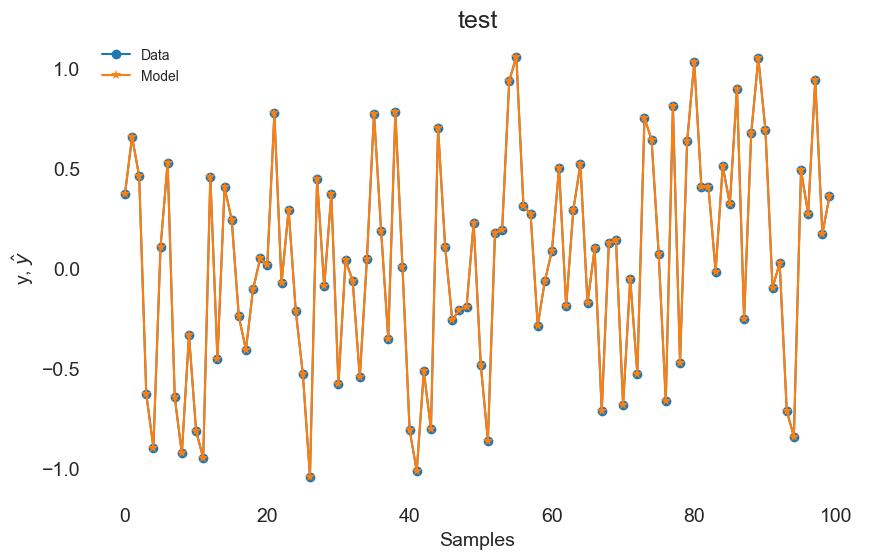

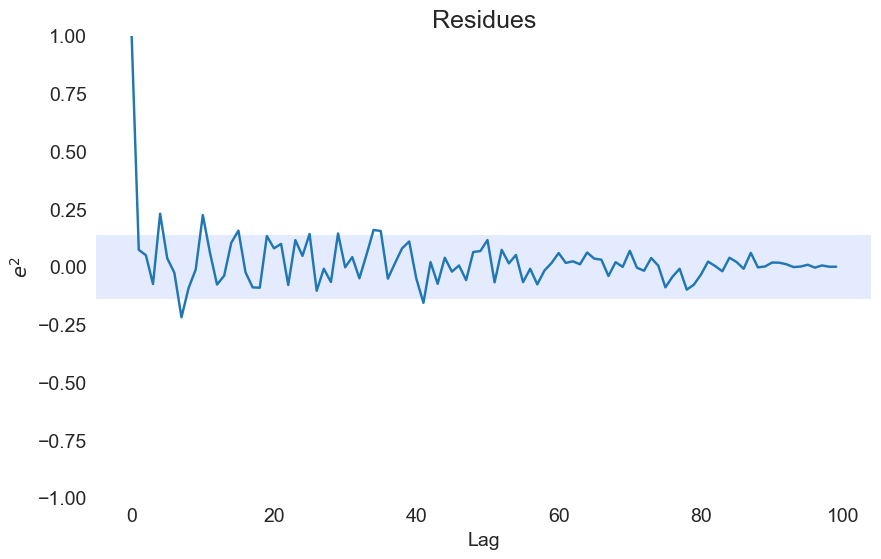

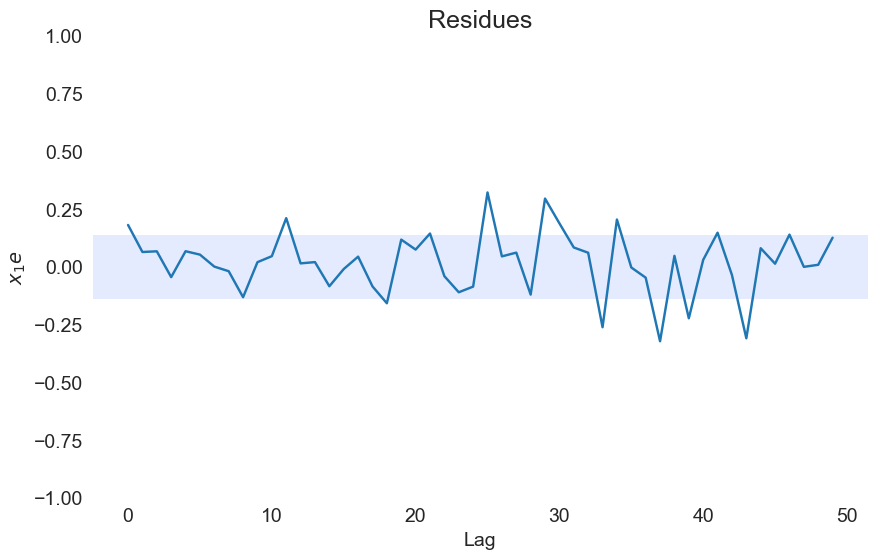

In [19]:
plot_results(y=y_valid, yhat=yhat, n=1000, title="test",
    xlabel="Samples",
    ylabel="y, $\hat{y}$",
    data_color="#1f77b4",
    model_color="#ff7f0e",
    marker="o",
    model_marker="*",
    linewidth=1.5,
    figsize=(10, 6),
    style='seaborn-v0_8-notebook',
    facecolor="white")
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$", style='seaborn-v0_8-notebook')
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$", style='seaborn-v0_8-notebook')

## Setting the *n_terms* parameter

In the example above we let the number of terms to compose the final model to be defined as the minimum value of the information criteria. Once you ran the algorithm and choose the best number of parameters, you can turn *order_selection* to *False* and set the *n_terms* value (3 in this example). Here we have a small dataset, but in bigger data this can be critical because running information criteria algorithm is more computational expensive. Since we already know the best number of regressor, we set *n_terms* and we get the same result.

However, this is not only critical because computational efficiency. In many situation, the minimum value of the information criteria can lead to overfitting. In some cases, the difference between choosing a model with 30 regressors or 10 is minimal, so you can take the model with 10 terms without loosing accuracy.

In the following we use *info_values* to plot the information criteria values. As you can see, the minimum value relies where $xaxis = 5$ 

Text(0, 0.5, 'Information Criteria')

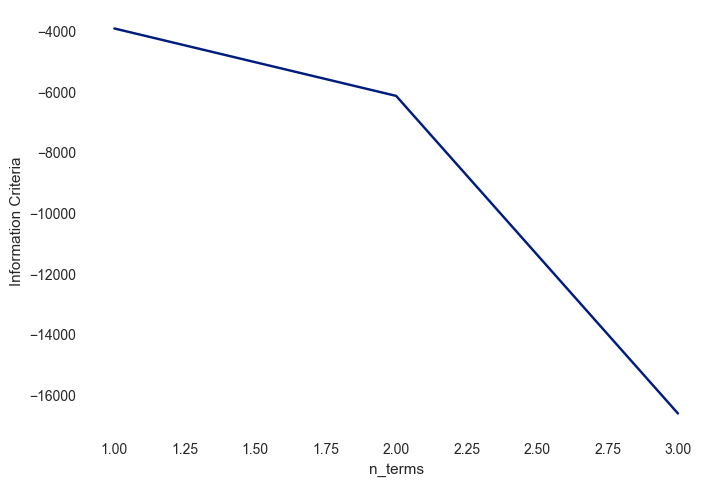

In [20]:
xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")

```{note}
 Here we are creating random samples with white noise and letting the algorithm choose
 the number of terms based on the minimum value of information criteria. 
 This is not the best approach in System Identification, but serves as a simple example. 
 The information criteria must be used as an __auxiliary tool__ to select *n_terms*. 
 Plot the information values to help you on that!

 If you run the example above several times you might find some cases where the
 algorithm choose only the first two regressors, or four (depending on the information
 criteria method selected). This is because the minimum value of information criteria
 depends on residual variance (affected by noise) and have some limitations in nonlinear
 scenarios. However, if you check the ERR values (robust to noise) you will see that the
 ERR is ordering the regressors in the correct way!

 We have some examples on *information_criteria* notebook!
```

```{note}
This documentation and the examples below are written with MyST Markdown, a form
of markdown that works with Sphinx. For more information about MyST markdown, and
to use MyST markdown with your Sphinx website,
see [the MyST-parser documentation](https://myst-parser.readthedocs.io/)
```

The *n_info_values* limits the number of regressors to apply the information criteria. We choose $n_y = n_x = \ell = 2$, so the candidate regressor is a list of 15 regressors. We can set *n_info_values = 15* and see the information values for all regressors. This option can save some amount of computational resources when dealing with multiples inputs and large datasets.

C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


Text(0, 0.5, 'Information Criteria')

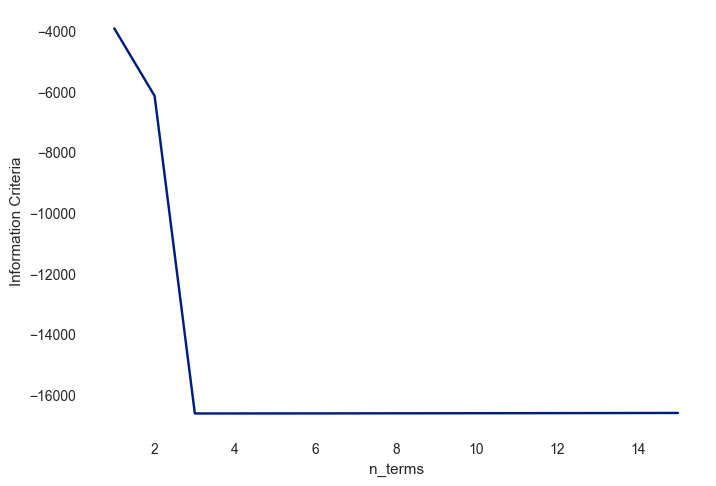

In [21]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=15,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)

model.fit(X=x_train, y=y_train)

xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")

Now running without executing information criteria methods (setting the *n_terms*) because we already know the optimal number of regressors

In [22]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=False,
    n_info_values=15,
    n_terms=3,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

0.00018456924095005924
      Regressors  Parameters             ERR
0        x1(k-2)  9.0001E-01  9.57505011E-01
1         y(k-1)  2.0001E-01  3.89117583E-02
2  x1(k-1)y(k-1)  9.9992E-02  3.58319976E-03


## Predict method

One could ask why it is necessary to pass the test data on the predict method. The answers is: you don't need to pass the test data when you are running a infinity-steps ahead prediction, you just need to pass the initial conditions. However, if you wants to check how your model performs in a 1-step ahead prediction or n-step ahead prediction, you should provide the test data.

To show you only need the initial condition, consider the following example using the previous trained model:

In [12]:
model.max_lag  # the number of initial conditions you should provide

2

In [13]:
yhat = model.predict(
    X=x_valid, y=y_valid[: model.max_lag]
)  # passing only the 2 initial values which will be used as initial conditions
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

0.000181454283142912


As you can see, the rrse obtained is the same as the one obtained when we input the full test data. That is due the fact that even in the cases you provide the full test data, the prediction method only uses the first values as initial conditions and drop the other values in the backend.

In the 1-step ahead prediction or n-steps ahead prediction you should provide the full test data because we handle all the computations in the background so the users don't need to care to implement the loops themselves.

If you wants the check how your model performs in a 3-steps ahead scenario using 200 samples in the test data, that means that at each 3 iterations the model feedback will use the real data as initial conditions. Thats why the full data test is necessary, because otherwise the model won't find the real value to use as feedback in the n-iteration.

This is the case where you have access the historical data so you can check how your model performs in n-steps ahead prediction. If you choose to use a 3-steps ahead model prediction in real life, you have to predict the next 3 samples, wait the 3 iterations, collect the real data and use the new data as initial condition to predict the next 3 values and so on.

In the infinity-steps ahead prediction scenario, if your model has a input it will be able to make predictions for all inputs by only providing the initial conditions. If your model has no input (a NAR model, for example), you can set the forecast horizon and the model will make predictions by using only the initial conditions. All the feedback will be the predicted values (this is, by the way, one of the reasons that usually n-steps ahead models are better than infinity-ahead models).

It is worth to mention that changing the initial condition doesn't mean you are changing your model. The only thing changing is the initial condition and that could make a real difference in many cases.

## Extra information

You can access some extra information like the list of all candidate regressors

In [14]:
# for now the list is returned as a codification. Here, $0$ is the constant term, $[1001]=y{k-1}, [100n]=y_{k-n}, [200n] = x1_{k-n}, [300n]=x2_{k-n}$ and so on
model.regressor_code  # list of all possible regressors given non_degree, n_y and n_x values

array([[   0,    0],
       [1001,    0],
       [1002,    0],
       [2001,    0],
       [2002,    0],
       [1001, 1001],
       [1002, 1001],
       [2001, 1001],
       [2002, 1001],
       [1002, 1002],
       [2001, 1002],
       [2002, 1002],
       [2001, 2001],
       [2002, 2001],
       [2002, 2002]])

In [15]:
print(model.err, "\n\n")  # err values for the selected terms
print(model.theta)  # estimated parameters for the final model structure

[0.95682838 0.03983615 0.00333543 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ] 


[[0.8999946 ]
 [0.19999538]
 [0.1000149 ]]
